In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


df=pd.read_csv("train_data.csv")
Y_train=df['Patv']
df1=pd.read_csv("val_data.csv")
Y_val=df1['Patv']
df2=pd.read_csv("test_data.csv")
Y_test=df2['Patv']
X2_train=df.drop(['Patv'],axis=1)
X2_val=df1.drop(['Patv'],axis=1)
X2_test=df2.drop(['Patv'],axis=1)

In [2]:
X2_train_series = X2_train.values.reshape((X2_train.shape[0], X2_train.shape[1], 1))
X2_test_series = X2_test.values.reshape((X2_test.shape[0], X2_test.shape[1], 1))
X2_valid_series = X2_val.values.reshape((X2_val.shape[0], X2_val.shape[1], 1))

subsequences = 3
timesteps = X2_train.shape[1]//subsequences
X2_train_series_sub = X2_train_series.reshape((X2_train_series.shape[0], subsequences, timesteps, 1))
X2_test_series_sub = X2_test_series.reshape((X2_test_series.shape[0], subsequences, timesteps, 1))
X2_valid_series_sub = X2_valid_series.reshape((X2_valid_series.shape[0], subsequences, timesteps, 1))
print('Train set shape', X2_train_series_sub.shape)
print('Validation set shape', X2_valid_series_sub.shape)

Train set shape (2836512, 3, 8, 1)
Validation set shape (945504, 3, 8, 1)


In [3]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X2_train_series_sub.shape[2], X2_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(64, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer='adam')

In [4]:
cnn_lstm_history = model_cnn_lstm.fit(X2_train_series_sub, Y_train, 
                                      validation_data=(X2_valid_series_sub, Y_val), epochs=75, verbose=2)

Epoch 1/75
88641/88641 - 411s - loss: 9347.0508 - val_loss: 9746.7002 - 411s/epoch - 5ms/step
Epoch 2/75
88641/88641 - 404s - loss: 6955.2993 - val_loss: 10171.5762 - 404s/epoch - 5ms/step
Epoch 3/75
88641/88641 - 382s - loss: 6603.3174 - val_loss: 9326.8203 - 382s/epoch - 4ms/step
Epoch 4/75
88641/88641 - 399s - loss: 6422.3804 - val_loss: 9846.3047 - 399s/epoch - 5ms/step
Epoch 5/75
88641/88641 - 399s - loss: 6259.2695 - val_loss: 9614.4941 - 399s/epoch - 5ms/step
Epoch 6/75
88641/88641 - 396s - loss: 6146.6274 - val_loss: 10106.6094 - 396s/epoch - 4ms/step
Epoch 7/75
88641/88641 - 399s - loss: 6100.6660 - val_loss: 9713.1602 - 399s/epoch - 5ms/step
Epoch 8/75
88641/88641 - 398s - loss: 6007.8315 - val_loss: 13358.5508 - 398s/epoch - 4ms/step
Epoch 9/75
88641/88641 - 398s - loss: 5967.1680 - val_loss: 9558.3945 - 398s/epoch - 4ms/step
Epoch 10/75
88641/88641 - 392s - loss: 5893.3584 - val_loss: 9791.7246 - 392s/epoch - 4ms/step
Epoch 11/75
88641/88641 - 388s - loss: 5924.3853 - val_l

In [5]:
from sklearn.metrics import mean_squared_error

cnn_lstm_train_pred = model_cnn_lstm.predict(X2_train_series_sub)
cnn_lstm_valid_pred = model_cnn_lstm.predict(X2_valid_series_sub)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_val, cnn_lstm_valid_pred)))

29547/29547 [==============================] - 114s 4ms/step
Train rmse: 71.17810561593218
Validation rmse: 97.03094405496202


29547/29547 [==============================] - 115s 4ms/step


(        Predictions  Actuals
 0         52.356285    55.13
 1         53.018738    55.13
 2         54.594421    55.13
 3         52.096657    55.13
 4         52.692406    55.13
 ...             ...      ...
 945499   691.027405   601.44
 945500   755.337097   673.79
 945501  1067.964233   999.36
 945502  1173.469849  1100.89
 945503  1218.335327  1181.49
 
 [945504 rows x 2 columns],
 12123.772592934696)

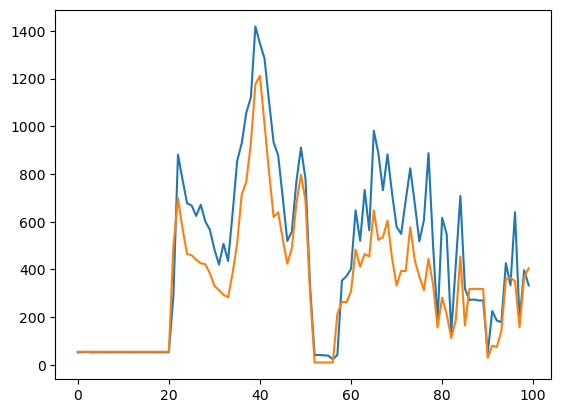

In [8]:
def plot_predictions1(model, X, y, start=0, end=100):
    predictions = model_cnn_lstm.predict(X).flatten()
    df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
    plt.plot(df['Predictions'][start:end])
    plt.plot(df['Actuals'][start:end])
    return df, mean_squared_error(y, predictions)

X2_test_series_sub = X2_test_series.reshape((X2_test_series.shape[0],subsequences,timesteps,1))
plot_predictions1(model_cnn_lstm, X2_test_series_sub, Y_test)